In [1]:
# Make module from local packages importable
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [14]:
import tensorflow as tf
import yaml
import numpy as np
import matplotlib.pyplot as plt

from db_utils.db_connection import SumatraDB

## Load model

In [3]:
DATA_PATH="../data"
RECORD_LABEL="20180606-110614"
RECORD_PATH=os.path.join(DATA_PATH, RECORD_LABEL)


# Query config from database
db = SumatraDB(db="../.smt/records")
COLUMNS = ["label", "reason", "timestamp", "tags", "parameters_id", "version"]
record = db.get_filtered_by_label(COLUMNS, RECORD_LABEL)[0]
config = db.get_params_dic(record.params_id)

# Create folder for generated plots
if not os.path.exists("generated_plots"):
    os.mkdir("generated_plots")

config

{'class': 'src.test_retest.mri.unsupervised_features.PCAAutoEncoderTuples',
 'params': {'config': {'keep_checkpoint_max': 1,
   'log_step_count_steps': 100,
   'save_checkpoints_steps': 200,
   'save_summary_steps': 1,
   'tf_random_seed': 42},
  'data_params': {'dump_out_dir': 'produced_data', 'not_needed': 'not'},
  'hooks': {'confusion_matrix': True, 'icc_c1': True},
  'input_fn_config': {'batch_size': 4, 'num_epochs': 5, 'shuffle': None},
  'params': {'hidden_dim': 128,
   'hidden_lambda': 10,
   'hidden_regularizer': 'js_divergence',
   'input_dim': 902629,
   'lambda_w': 0,
   'learning_rate': 0.001,
   'n_classes': 10,
   'weight_regularizer': 'l2'},
  'streamer': {'class': 'src.data.streaming.mri_streaming.MRISamePatientSameAgePairStream',
   'params': {'stream_config': {'balanced_labels': ['healthy', 'health_ad'],
     'batch_size': 16,
     'data_sources': [{'glob_pattern': '/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/*_*.nii.gz',
       'id_from_filename': {'regex_id_g

In [4]:
import importlib
# Load python class to construct object
full_path = config["class"]
module_string = ".".join(full_path.split(".")[:-1])
module = importlib.import_module(module_string)
class_ = getattr(module, full_path.split(".")[-1])
# Don't need streamer
config["params"]["streamer"] = None
obj = class_(**config["params"])

In [5]:
# Construct estimator
est = tf.estimator.Estimator(
    model_fn=obj.model_fn,
    model_dir=RECORD_PATH,
    params=config["params"]["params"]
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../data/20180606-110614', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7ff9088de7b8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Analyze PCA transformation

In [6]:
W = est.get_variable_value('weights')

In [7]:
W.shape  # columns are principal components

(902629, 128)

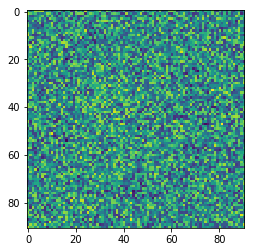

In [8]:
component = 3
image_shape = (91, 109, 91)
principal_vec = W[:, component]
vec_as_image = np.reshape(principal_vec, image_shape)
plt.imshow(vec_as_image[:, 50, :])

#### Reconstruct an image

In [30]:
image_label = "7302"
embedding_path = os.path.join("..", "produced_data", RECORD_LABEL, "train_4", image_label + "_mni_aligned.npy")
embedding = np.load(embedding_path)

In [36]:
reconstruction = np.matmul(np.reshape(embedding, (1, -1)), W.T)

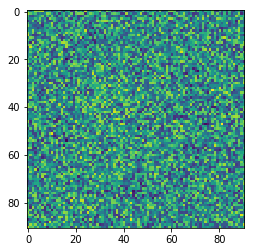

In [37]:
rec_image = np.reshape(reconstruction, image_shape)
plt.imshow(vec_as_image[:, 50, :])

In [38]:
# original image
import nibabel as nib

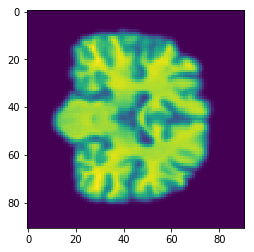

In [39]:
path = "/local/ADNI_AIBL/ADNI_AIBL_T1_smoothed/all_images/" + image_label + "_mni_aligned.nii.gz"
orig_im = nib.load(path).get_data()
orig_im = np.reshape(orig_im, image_shape)
plt.imshow(orig_im[:, 50, :])

In [40]:
np.linalg.norm(orig_im - rec_image)

45821.266

### Compute test_loss